<table align="center">
  <td align="center"><a target="_blank" href="http://introtodeeplearning.com">
        <img src="https://i.ibb.co/Jr88sn2/mit.png" style="padding-bottom:5px;" />
      Visit MIT Deep Learning</a></td>
  <td align="center"><a target="_blank" href="https://colab.research.google.com/github/aamini/introtodeeplearning/blob/2023/lab3/solutions/Lab3_Part_1_Introduction_to_CAPSA.ipynb">
        <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/aamini/introtodeeplearning/blob/2023/lab3/solutions/Lab3_Part_1_Introduction_to_CAPSA.ipynb">
        <img src="https://i.ibb.co/xfJbPmL/github.png"  height="70px" style="padding-bottom:5px;"  />View Source on GitHub</a></td>
</table>

# Copyright Information

In [ ]:
# Copyright 2023 MIT Introduction to Deep Learning. All Rights Reserved.
# 
# Licensed under the MIT License. You may not use this file except in compliance
# with the License. Use and/or modification of this code outside of MIT Introduction
# to Deep Learning must reference:
#
# © MIT Introduction to Deep Learning
# http://introtodeeplearning.com
#

# Laboratory 3: Debiasing, Uncertainty, and Robustness

# Part 2: Mitigating Bias and Uncertainty in Facial Detection Systems

In Lab 2, we defined a semi-supervised VAE (SS-VAE) to diagnose feature representation disparities and biases in facial detection systems. In Lab 3 Part 1, we gained experience with [Capsa](https://github.com/themis-ai/capsa/) and its ability to build risk-aware models automatically through wrapping. Now in this lab, we will put these two together: using Capsa to build systems that can *automatically* uncover and mitigate bias and uncertainty in facial detection systems.

As we have seen, automatically detecting and mitigating bias and uncertainty is crucial to deploying fair and safe models. Building off our foundation with Capsa, developed by [Themis AI](https://themisai.io/), we will now use Capsa for the facial detection problem, in order to diagnose risks in facial detection models. You will then design and create strategies to mitigate these risks, with goal of improving model performance across the entire facial detection dataset.

**Your goal in this lab -- and the associated competition -- is to design a strategic solution for bias and uncertainty mitigation, using Capsa.** The approaches and solutions with oustanding performance will be recognized with outstanding prizes! Details on the submission process are at the end of this lab.

![Capsa overview](https://raw.githubusercontent.com/aamini/introtodeeplearning/2023/lab3/img/capsa_overview.png)

Let's get started by installing the necessary dependencies:

In [ ]:
!git clone -b 2023 https://github.com/aamini/introtodeeplearning.git
%cd introtodeeplearning/
%pip install -e .

Cloning into 'introtodeeplearning'...
remote: Enumerating objects: 2354, done.
remote: Counting objects: 100% (337/337), done.
remote: Compressing objects: 100% (162/162), done.
remote: Total 2354 (delta 207), reused 284 (delta 172), pack-reused 2017
Receiving objects: 100% (2354/2354), 136.06 MiB | 27.14 MiB/s, done.
Resolving deltas: 100% (1334/1334), done.
/content/introtodeeplearning
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/introtodeeplearning
  Preparing metadata (setup.py) ... done
  Running setup.py develop for mitdeeplearning


In [ ]:
# Import Tensorflow 2.0
#%tensorflow_version 2.x
import tensorflow as tf

import IPython
import functools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from capsa import *

# Download and import the MIT 6.S191 package
import mitdeeplearning as mdl

# Download and import capsa
!pip install capsa
import capsa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 3.1 Datasets

Since we are again focusing on the facial detection problem, we will use the same datasets from Lab 2. To remind you, we have a dataset of positive examples (i.e., of faces) and a dataset of negative examples (i.e., of things that are not faces).

1.   **Positive training data**: [CelebA Dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). A large-scale dataset (over 200K images) of celebrity faces.   
2.   **Negative training data**: [ImageNet](http://www.image-net.org/). A large-scale dataset with many images across many different categories. We will take negative examples from a variety of non-human categories.

We will evaluate trained models on an independent test dataset of face images to diagnose and mitigate potential issues with *bias, fairness, and confidence*. This will be a larger test dataset for evaluation purposes.

We begin by importing these datasets. We have defined a `DatasetLoader` class that does a bit of data pre-processing to import the training data in a usable format.

In [ ]:
batch_size = 32

# Get the training data: both images from CelebA and ImageNet
path_to_training_data = tf.keras.utils.get_file('train_face_2023_v2.h5', 'https://www.dropbox.com/s/b5z1cd317y5u1tr/train_face_2023_v2.h5?dl=1')
# Instantiate a DatasetLoader using the downloaded dataset
train_loader = mdl.lab3.DatasetLoader(path_to_training_data, training=True, batch_size=batch_size)
test_loader = mdl.lab3.DatasetLoader(path_to_training_data, training=False, batch_size=batch_size)

1350735194/1350735194 [==============================] - 32s 0us/step
Opening /root/.keras/datasets/train_face_2023_v2.h5
Loading data into memory...
Opening /root/.keras/datasets/train_face_2023_v2.h5
Loading data into memory...


### Building robustness to bias and uncertainty

Remember that we'll be training our facial detection classifiers on the large, well-curated CelebA dataset (and ImageNet), and then evaluating their accuracy by testing them on an independent test dataset. We want to mitigate the effects of unwanted bias and uncertainty on the model's predictions and performance. Your goal is to build the best-performing, most robust model, one that achieves high classification accuracy across the entire test dataset.

To achieve this, you may want to consider the three metrics introduced with Capsa: (1) representation bias, (2) data or aleatoric uncertainty, and (3) model or epistemic uncertainty. Note that all three of these metrics are different! For example, we can have well-represented examples that still have high epistemic uncertainty. Think about how you may use these metrics to improve the performance of your model.

# 3.2 Risk-aware facial detection with Capsa

In Lab 2, we built a semi-supervised variational autoencoder (SS-VAE) to learn the latent structure of our database and to uncover feature representation disparities, inspired by the approach of [uncover hidden biases](http://introtodeeplearning.com/AAAI_MitigatingAlgorithmicBias.pdf). In this lab, we'll show that we can use Capsa to build the same VAE in one line!

This sets the foundation for quantifying a key risk metric -- representation bias -- for the facial detection problem. In working to improve your model's performance, you will want to consider representation bias carefully and think about how you could mitigate the effect of representation bias.

Just like in Lab 2, we begin by defining a standard CNN-based classifier. We will then use Capsa to wrap the model and build the risk-aware VAE variant.

In [ ]:
### Define the CNN classifier model ###

'''Function to define a standard CNN model'''
def make_standard_classifier(n_outputs=1, n_filters=12):
  Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

  model = tf.keras.Sequential([ 
    tf.keras.Input(shape=(64,64, 3)),
    Conv2D(filters=1*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),
    
    Conv2D(filters=2*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),

    Conv2D(filters=4*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Conv2D(filters=6*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Conv2D(filters=8*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Flatten(),
    Dense(512),
    Dense(n_outputs, activation=None),
  ])
  return model

### Capsa's `HistogramVAEWrapper`

With our base classifier Capsa allows us to automatically define a VAE implementing that base classifier. Capsa's [`HistogramVAEWrapper`](https://themisai.io/capsa/api_documentation/HistogramVAEWrapper.html) builds this VAE to analyze the latent space distribution, just as we did in Lab 2. 

Specifically, `capsa.HistogramVAEWrapper` constructs a histogram with `num_bins` bins across every dimension of the latent space, and then calculates the joint probability of every sample according to the constructed histograms. The samples with the lowest joint probability have the lowest representation; the samples with the highest joint probability have the highest representation.

`capsa.HistogramVAEWrapper` takes in a number of arguments including:
1. `base_model`: the model to be transformed into the risk-aware variant.
2. `num_bins`: the number of bins we want to discretize our distribution into. 
2. `queue_size`: the number of samples we want to track at any given point.
3. `decoder`: the decoder architecture for the VAE.

We define the same decoder as in Lab 2:

In [ ]:
### Define the decoder architecture for the facial detection VAE ###

def make_face_decoder_network(n_filters=12):
  # Functionally define the different layer types we will use
  Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, 
                                      padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
  Reshape = tf.keras.layers.Reshape

  # Build the decoder network using the Sequential API
  decoder = tf.keras.Sequential([
    # Transform to pre-convolutional generation
    Dense(units=2*2*8*n_filters),  # 4x4 feature maps (with 6N occurances)
    Reshape(target_shape=(2, 2, 8*n_filters)),

    # Upscaling convolutions (inverse of encoder)
    Conv2DTranspose(filters=6*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=4*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=2*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=1*n_filters, kernel_size=5,  strides=2),
    Conv2DTranspose(filters=3, kernel_size=5,  strides=2),
  ])

  return decoder

We are ready to create the wrapped model using `capsa.HistogramVAEWrapper` by passing in the relevant arguments!

Just like in the wrappers in the Introduction to Capsa lab, we can take our standard CNN classifier, wrap it with `capsa.HistogramVAEWrapper`, build the wrapped model. The wrapper then enablings semi-supervised training for the facial detection task. As the wrapped model trains, the classifier weights are updated, and the VAE-wrapped model learns to track feature distributions over the latent space. More details of the `HistogramVAEWrapper` and how it can be used are [available here](https://themisai.io/capsa/api_documentation/HistogramVAEWrapper.html).

We can then evaluate the representation bias of the classifier on the test dataset. By calling the `wrapped_model` on our test data, we can automatically generate representation bias and uncertainty scores that are normally manually calculated. Let's wrap our base CNN classifier using Capsa, train and build the resulting model, and start to process the test data: 

In [ ]:
### Estimating representation bias with Capsa HistogramVAEWrapper ###

model = make_standard_classifier()
# Wrap the CNN classifier for latent encoding with a VAE wrapper
wrapped_model = capsa.HistogramVAEWrapper(model, num_bins=5, queue_size=20000, 
    latent_dim = 32, decoder=make_face_decoder_network())

# Build the model for classification, defining the loss function, optimizer, and metrics
wrapped_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), # for classification
    metrics=[tf.keras.metrics.BinaryAccuracy()], # for classification
    run_eagerly=True
)

# Train the wrapped model for 6 epochs by fitting to the training data
history = wrapped_model.fit(
        train_loader,
        epochs=6,
        batch_size=batch_size,
  )

## Evaluation

# Get all faces from the testing dataset
test_imgs = test_loader.get_all_faces()

# Call the Capsa-wrapped classifier to generate outputs: predictions, uncertainty, and bias!
predictions, uncertainty, bias = wrapped_model.predict(test_imgs, batch_size=512)

# 3.3 Analyzing representation bias with Capsa

From the above output, we have an estimate for the representation bias score! We can analyze the representation scores to start to think about manifestations of bias in the facial detection dataset. Before you run the next code block, which faces would you expect to be underrepresented in the dataset? Which ones do you think will be overrepresented?

In [ ]:
### Analyzing representation bias scores ###

# Sort according to lowest to highest representation scores
indices = np.argsort(bias, axis=None) # sort the score values themselves
sorted_images = test_imgs[indices] # sort images from lowest to highest representations
sorted_biases = bias[indices] # order the representation bias scores
sorted_preds = predictions[indices] # order the prediction values

# Visualize the 20 images with the lowest representation in the test dataset
plt.imshow(mdl.util.create_grid_of_images(sorted_images[:20], (4, 5)))

# Visualize the 20 images with the highest representation in the test dataset
plt.imshow(mdl.util.create_grid_of_images(sorted_images[-20:0], (4, 5)))

We can also quantify how the representation density relates to the classification accuracy by plotting the two against each other:

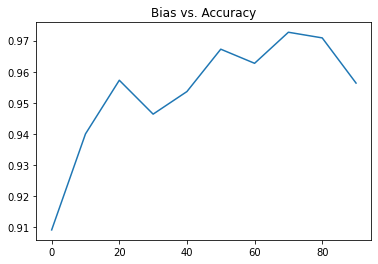

<Figure size 432x288 with 0 Axes>

In [ ]:
averaged_imgs = mdl.lab3.plot_accuracy_vs_risk(sorted_images, sorted_biases, sorted_preds, "Bias vs. Accuracy")

These representations scores relate back to data examples, so we can visualize what the average face looks like for a gien *percentile* of representation density:

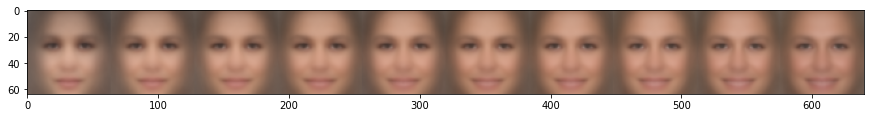

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
ax.imshow(mdl.util.create_grid_of_images(averaged_imgs, (1,10)))

#### **TODO: Scoring representation densities with Capsa**

Write short answers to the questions below to complete the `TODO`s:

1. How does accuracy relate to the representation score? From this relationship, what can you determine about the bias underlying the dataset?
2. What does the average face in the 10th percentile of representation density look like (i.e., the face for which 10% of the data have lower probability of occuring)? What about the 90th percentile? What changes across these faces?
3. What could be potential limitations of the `HistogramVAEWrapper` approach as it is implemented now?

# 3.4 Analyzing epistemic uncertainty with Capsa

Recall that *epistemic* uncertainty, or a model's uncertainty in its prediction, can arise from out-of-distribution data, missing data, or samples that are harder to learn. This does not necessarily correlate with representation bias! Imagine the scenario of training an object detector for self-driving cars: even if the model is presented with many cluttered scenes, these samples still may be harder to learn than scenes with very few objects in them.

We will now use our VAE-wrapped facial detection classifier to analyze and estimate the epistemic uncertainty of the model trained on the facial detection task.

While most methods of estimating epistemic uncertainty are *sampling-based*, we can also use ***reconstruction-based*** methods -- like using VAEs -- to estimate epistemic uncertainty. If a model is unable to provide a good reconstruction for a given data point, it has not learned that area of the underlying data distribution well, and therefore has high epistemic uncertainty.



Since we've already used the `HistogramVAEWrapper` to calculate the histograms for representation bias quantification, we can use the exact same VAE wrapper to shed insight into epistemic uncertainty! Capsa helps us do exactly that. When we called the model, we returned the classification prediction, uncertainty, and bias for every sample:
`predictions, uncertainty, bias = wrapped_model.predict(test_imgs, batch_size=512)`.

Let's analyze these estimated uncertainties:

In [ ]:
### Analyzing epistemic uncertainty estimates ###

# Sort according to epistemic uncertainty estimates
epistemic_indices = np.argsort(uncertainty, axis=None) # sort the uncertainty values
epistemic_images = test_imgs[epistemic_indices] # sort images from lowest to highest uncertainty
sorted_epistemic = uncertainty[epistemic_indices] # order the uncertainty scores
sorted_epistemic_preds = predictions[epistemic_indices] # order the prediction values

# Visualize the 20 images with the LEAST epistemic uncertainty
plt.imshow(mdl.util.create_grid_of_images(epistemic_images[:20], (4, 5)))

# Visualize the 20 images with the MOST epistemic uncertainty
plt.imshow(mdl.util.create_grid_of_images(epistemic_images[:20], (4, 5)))

We quantify how the epistemic uncertainty relates to the classification accuracy by plotting the two against each other:

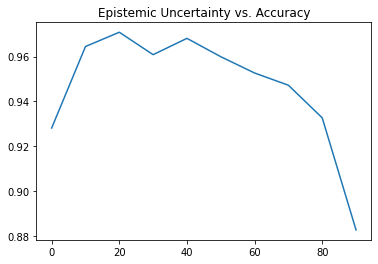

<Figure size 432x288 with 0 Axes>

In [ ]:
_ = lab3.plot_accuracy_vs_risk(epistemic_images, sorted_epistemic, sorted_epistemic_preds, "Epistemic Uncertainty vs. Accuracy")

#### **TODO: Estimating epistemic uncertainties with Capsa**

Write short answers to the questions below to complete the `TODO`s:

1. How does accuracy relate to the epistemic uncertainty?
2. How do the results for epistemic uncertainty compare to the results for representation bias? Was this expected or unexpted? Why?
3. What may be instances in the facial detection task that could have high representation density but also high uncertainty? 

# 3.4 Resampling based on risk metrics
 Then, our goal will be to continue our implementation of the DB-VAE and use the latent variables learned via a VAE to adaptively re-sample the CelebA data during training. Specifically, we will alter the probability that a given image is used during training based on how often its latent features appear in the dataset. So, faces with rarer features (like dark skin, sunglasses, or hats) should become more likely to be sampled during training, while the sampling probability for faces with features that are over-represented in the training dataset should decrease (relative to uniform random sampling across the training data).

  and we want to oversample these. Conversely, we want to undersample the areas of the dataset with the highest bias.


Finally, let's use both the bias score and the reconstruction loss to adaptively resample from our dataset. Since we can calculate this score on-the-fly *during training*, we can adjust the probability of samples being chosen. 

Note that we want to debias and amplify only the *positive* samples in the dataset, so we're going to only adjust probabilities and calculate scores for these samples. 

We want to *amplify*, or increase the probability of sampling, of images with high epistemic uncertainty, since these data points come from areas of the latent distribution that the model hasn't learned very well yet. We also want to amplify images with very low representation bias, since otherwise, the model won't see enough of these samples during training. Let's define two functions below to do this:

First, let's do this for the bias. We have a smoothing parameter `alpha` that we can tune: as `alpha` increases, the probabilities will tend towards a uniform distribution, and as `alpha` decreases, the probabilities will correlate more directly with the bias. 

In [ ]:
def score_to_probability_bias(score, alpha):
    score = score + alpha
    probabilities = 1/score
    probabilities = probabilities/sum(probabilities)
    return probabilities

Let's now define a similar function for the epistemic probabilities: note that in this case, we want high epistemic uncertainty to correlate with a higher probability!

In [ ]:
def score_to_probability_epistemic(score, beta):
    score = score + beta
    probabilities = score/sum(score)
    return probabilities

Now, let's redefine and re-train our debiasing model!

In [ ]:
standard_classifier = make_standard_classifier()
dbvae = HistogramVAEWrapper(standard_classifier, latent_dim=100, num_bins=5, queue_size=2000, decoder=make_face_decoder_network())
dbvae.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=[tf.keras.metrics.BinaryAccuracy()])
train_imgs = train_loader.get_all_faces()

In [ ]:
# The training loop -- outer loop iterates over the number of epochs
for i in range(6):

  print("Starting epoch {}/{}".format(i+1, 6))
  
  # get a batch of training data and compute the training step
  for step, data in enumerate(train_loader):
    metrics = dbvae.train_step(data)
    if step % 100 == 0:
        print(step)
  _, recon_loss, bias_scores = dbvae(train_imgs)
  recon_loss = np.squeeze(recon_loss)

  # Recompute data sampling proabilities
  p_faces = score_to_probability_bias(bias_scores.numpy(), 1e-7)
  p_recon = score_to_probability_epistemic(recon_loss, 1e-7)
  p_final = (p_faces + p_recon)/2
  p_final /= sum(p_final)
  
  train_loader.p_pos = p_final

Now, we should have a debiased model that also mitigates some forms of uncertainty! Let's see how well our model does:

# 3.5 Evaluation

Let's run the same analyses as before, and plot the accuracy vs. the bias and accuracy vs. epistemic uncertainty. We want the model to do better on less biased and more uncertain samples than it did previously


In [ ]:
predictions, reconstruction_loss, bias = dbvae.predict(test_imgs)

In [ ]:
indices = np.argsort(bias, axis=None)
bias_images = test_imgs[indices]
sorted_bias = bias[indices]
sorted_bias_preds = predictions[indices]
_ = lab3.plot_accuracy_vs_risk(bias_images, sorted_bias, sorted_bias_preds, "Bias vs. Accuracy")

In [ ]:
indices = np.argsort(reconstruction_loss, axis=None)
epistemic_images = test_imgs[indices]
sorted_epistemic = bias[indices]
sorted_epistemic_preds = predictions[indices]
_ = lab3.plot_accuracy_vs_risk(epistemic_images, sorted_epistemic, sorted_epistemic_preds, "Epistemic Uncertainty vs. Accuracy")

# 3.6 Conclusion

We encourage you to think about and maybe even address some questions raised by the approach and results outlined here:

* We did not analyze the *aleatoric* uncertainty of the above dataset. Try to develop a similar approach (assigning probabilities based on aleatoric uncertainty) and incorporate this as well! You may find some surprising results :)

* How can the performance of the classifier above be improved even further? We purposely did not optimize hyperparameters to leave this up to you!

* How can you use other methods of uncertainty in CAPSA to strengthen your uncertainty estimates?

* In which applications (either related to facial detection or not!) would debiasing in this way be desired? Are there applications where you may not want to debias your model?

* Try to optimize your model to achieve improved performance. MIT students and affiliates will be eligible for prizes during the IAP offering. To enter the competition, MIT students and affiliates should upload the following to the course Canvas:

* Jupyter notebook with the code you used to generate your results;
copy of the line plots from section 3.5 showing the performance of your model;
* a description and/or diagram of the architecture and hyperparameters you used -- if there are any additional or interesting modifications you made to the template code, please include these in your description;
* discussion of why these modifications helped improve performance.

Hopefully this lab has shed some light on a few concepts, from vision based tasks, to VAEs, to algorithmic bias. We like to think it has, but we're biased ;).